In [1]:
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device}")

Using mps


In [3]:
shipments = pd.read_csv('data/delay.csv')
shipments.sample(10)

,ID,warehouse_block,mode_of_shipment,customer_care_calls,customer_rating,product_cost,prior_purchases,product_importance,gender,discount,weight_in_gms,on_time
8345,8346,F,Road,4,4,269,5,medium,F,2,1473,0
4284,4285,D,Ship,5,5,165,4,medium,F,3,4242,0
3535,3536,F,Road,6,3,222,5,high,F,2,4612,0
9385,9386,F,Ship,5,1,151,3,medium,F,9,5667,0
270,271,D,Flight,3,2,209,5,medium,F,12,3054,1
7691,7692,F,Ship,4,3,140,2,medium,F,2,5042,0
10039,10040,F,Ship,5,3,229,2,medium,F,1,5294,1
6869,6870,F,Ship,4,2,273,5,low,F,4,1223,1
1758,1759,D,Road,3,2,267,5,low,F,48,2622,1
7734,7735,D,Ship,5,4,259,5,low,F,4,1991,1


In [4]:
shipments = shipments.drop(columns=['ID'])
shipments = pd.get_dummies(shipments, columns=['warehouse_block', 'mode_of_shipment', 'gender'], drop_first=True)
shipments['product_importance'] = shipments.product_importance.map({'low': 1, 'medium': 2, 'high': 3})
shipments.head()

,customer_care_calls,customer_rating,product_cost,prior_purchases,product_importance,discount,weight_in_gms,on_time,warehouse_block_B,warehouse_block_C,warehouse_block_D,warehouse_block_F,mode_of_shipment_Road,mode_of_shipment_Ship,gender_M
0,4,2,177,3,1,44,1233,1,False,False,True,False,False,False,False
1,4,5,216,2,1,59,3088,1,False,False,False,True,False,False,True
2,2,2,183,4,1,48,3374,1,False,False,False,False,False,False,True
3,3,3,176,4,2,10,1177,1,True,False,False,False,False,False,True
4,2,2,184,3,2,46,2484,1,False,True,False,False,False,False,False


In [5]:
X = shipments.drop(columns='on_time')
y = shipments.on_time.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
class DelayDataset(torch.utils.data.Dataset):

    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        data = self.X[index]
        on_time = self.y[index].unsqueeze(0)  # extra Dimension
        return data, on_time

## Batch Normalization

![batch-norm](./assets/batch-norm.png)

1. Input: jedes Feature, jetzt: alle Outputs eines Layers
2. $\mu$ und $\sigma$ berechnen
3. Normalisieren $N(\mu, \sigma) \rightarrow N(0,1)$
4. $\gamma$ und $\beta$ shiften/scalen
5. Empfohlen in jedem Layer - vor/nach Aktivierungsfunktion [umstritten](https://www.reddit.com/r/MachineLearning/comments/67gonq/d_batch_normalization_before_or_after_relu/)

$\gamma$ und $\beta$ sind Parameter

In [12]:
model = nn.Sequential(
    nn.Linear(100, 128),
    nn.BatchNorm1d(128),
)

with torch.no_grad():
    x = torch.randn(32, 100) # 32 samples, 100 features
    y = model(x)
    print(y[:,0].mean(), y[:,0].std())

tensor(0.) tensor(1.0160)


In [8]:
model = nn.Sequential( # for simple networks a class can be omitted
    nn.Linear(X_train.shape[1], 8),
    nn.ReLU(),
    nn.BatchNorm1d(8),
    nn.Linear(8, 8, bias=False),
    nn.ReLU(),
    nn.BatchNorm1d(8),
    nn.Linear(8, 1, bias=False),
    nn.Sigmoid(),
).to(device)
print(model)

Sequential(
  (0): Linear(in_features=14, out_features=8, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=8, out_features=8, bias=False)
  (4): ReLU()
  (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=8, out_features=1, bias=False)
  (7): Sigmoid()
)


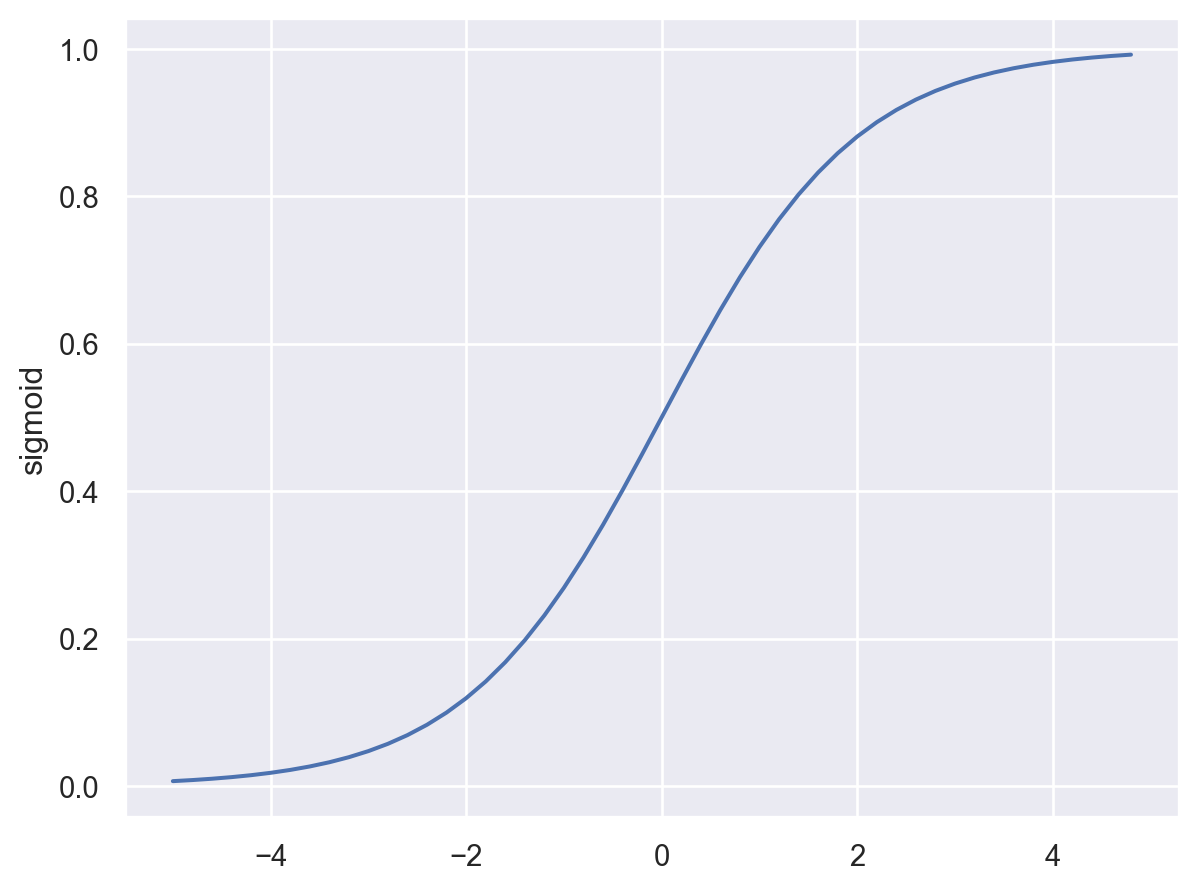

In [9]:
(so.Plot(x=torch.arange(-5, 5, 0.2))
    .add(so.Line(), y=torch.sigmoid(torch.arange(-5, 5, 0.2)))
 .label(x='', y = 'sigmoid'))

In [10]:
batch_size = 32
training_data = DelayDataset(X_train, y_train)
test_data = DelayDataset(X_test, y_test)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    model.train()
    running_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        running_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return running_loss / num_batches


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).sum().item()

    test_loss /= num_batches
    accuracy = correct / size
    return test_loss, accuracy

## Loss Function - (Binary) Cross Entropy

* 1 Feature, Prediction rot/grün  
![](./assets/bce1.webp)
* splitten für Sigmoid  
![](./assets/bce2.webp)
![](./assets/bce3.webp)
* Predictions (P(X ist grün)):  
![](./assets/bce4.webp)
![](./assets/bce5.webp)
* kleine Fehler sind nicht schlimm, große sollen bestraft werden

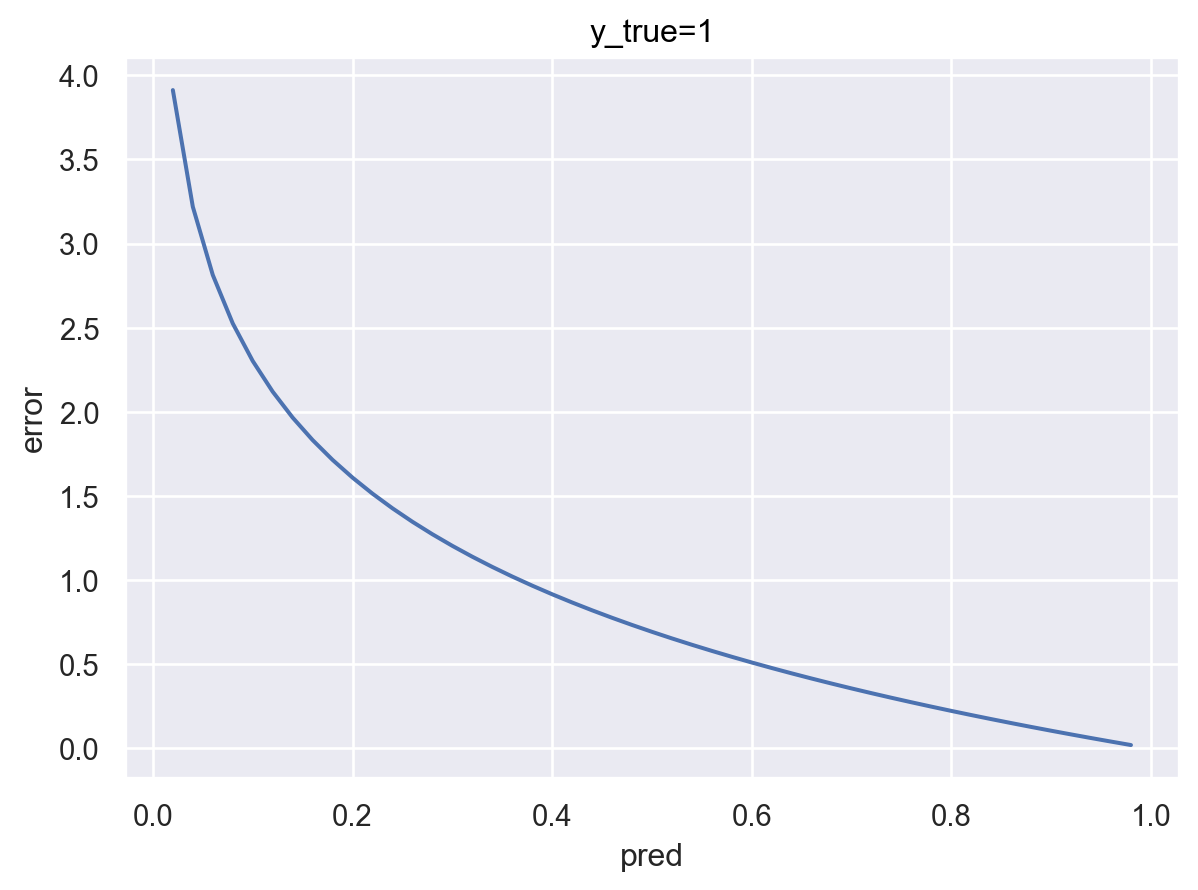

In [12]:
(so.Plot(x=torch.arange(0, 1, 0.02))
    .add(so.Line(), y=-torch.log(torch.arange(0, 1, 0.02)))
 .label(title='y_true=1', x='pred', y = 'error'))

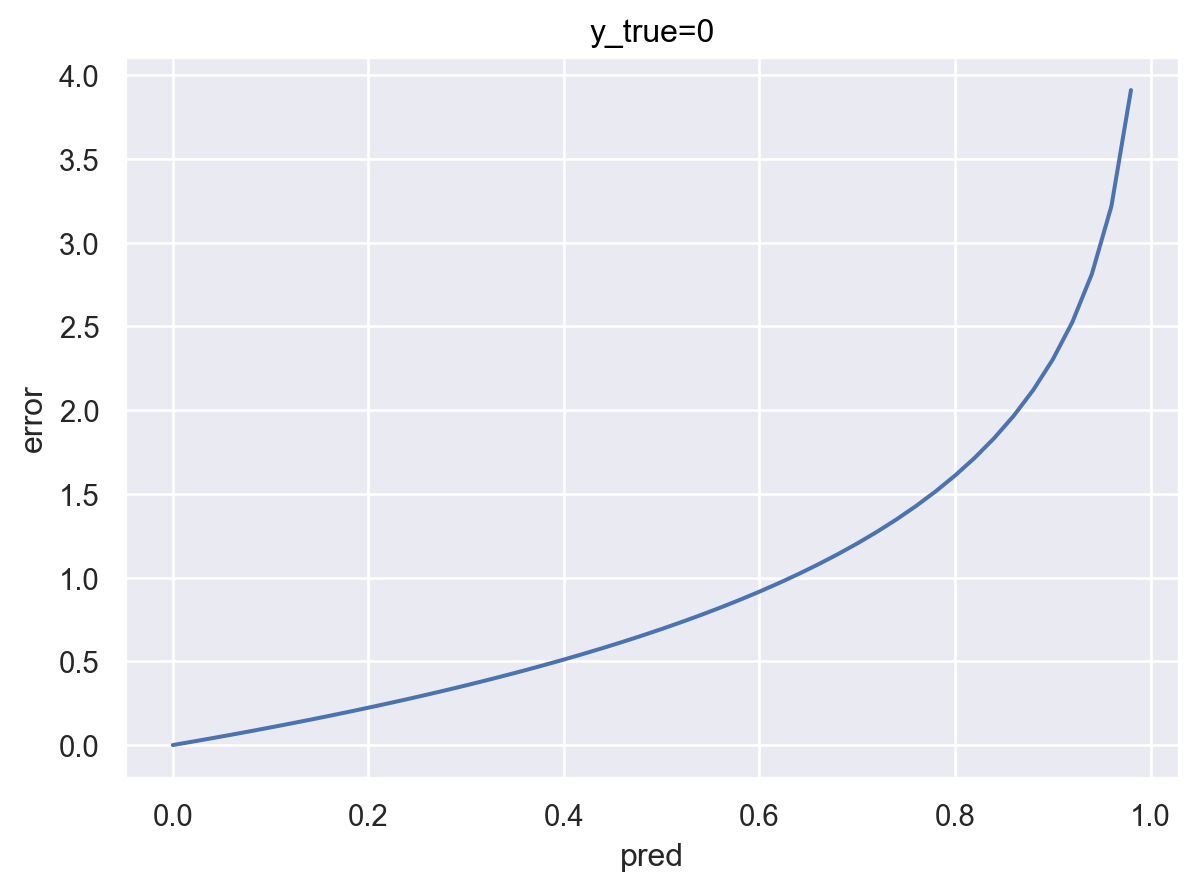

In [13]:
(so.Plot(x=torch.arange(0, 1, 0.02))
    .add(so.Line(), y=-torch.log(torch.arange(1, 0, -0.02)))
 .label(title='y_true=0', x='pred', y = 'error'))

![](./assets/bce6.webp)

## Mathe

| y | pred | error | -log(pred) |
|---|------|-------|-------------|
| 0 | 0    | 0     | 0      |
| 1 | 0.99 | 0.01  | 0.01        |
| 1 | 0.9  | 0.1   | 0.10        |
| 1 | 0.1  | 0.9   | 2.30        |
| 1 | 0.01 | 0.99  | 4.61        |
| 0 | 0.01 | 0.01  | 4.61        |

* kleine Fehler sind nicht so schlimm $$log(p)$$
* log ist negativ in [0,1] $$-log(p)$$
* für $y=0$ interessiert uns $$-log(1-p)$$
* durchschnittlicher Fehler $$\frac{1}{N}\sum{-log(p)}$$
* bei 2 Klassen und $$y_i = 0, 1; p_i = P(X \mbox{ in } y_i)$$
  $$\frac{1}{N}\sum{-((1-y_i) \log(1-p_i) + y_i \log(p_i))}$$

[![](./assets/bce-video.png)](https://www.youtube.com/watch?v=DPSXVJF5jIs)

Epoch 0
-------------------------------
Training_loss: 0.5196198696439916
Test_loss: 0.5207528778608295
Accuracy: 0.6631818181818182

Epoch 10
-------------------------------
Training_loss: 0.513108775398948
Test_loss: 0.512673918319785
Accuracy: 0.6713636363636364

No progress, aborting


<Axes: >

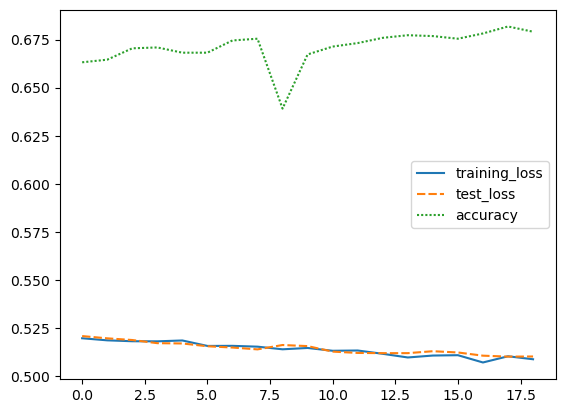

In [17]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metrics = {'training_loss': [], 'test_loss': [], 'accuracy': []}


def no_progress(metric_history, delta, patience=10):
    if len(metric_history) < patience:
        return False
    last_entries = metric_history[-patience:]
    return max(last_entries) - min(last_entries) < delta


for t in range(100):
    training_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    metrics['training_loss'].append(training_loss)
    test_loss, accuracy = test_loop(test_dataloader, model, loss_fn)
    metrics['test_loss'].append(test_loss)
    metrics['accuracy'].append(accuracy)
    if no_progress(metrics['accuracy'], delta=0.02):
        print('No progress, aborting')
        break
    if t % 10 == 0:
        print(f"Epoch {t}\n-------------------------------")
        print(f'Training_loss: {training_loss}')
        print(f'Test_loss: {test_loss}')
        print(f'Accuracy: {accuracy}')
        print()

sns.lineplot(data=metrics)

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

with torch.no_grad():
    tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
    y_pred = torch.round(model.forward(tensor)).cpu()
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

[[681 206]
 [527 786]]
              precision    recall  f1-score   support

           0       0.56      0.77      0.65       887
           1       0.79      0.60      0.68      1313

    accuracy                           0.67      2200
   macro avg       0.68      0.68      0.67      2200
weighted avg       0.70      0.67      0.67      2200


## weitere Extensions während des Trainings

* logging
* weight-Savepoints
* Speichern der besten weights